In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#from torchtext.legacy.datasets import Multi30k
#from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        assert kernel_size % 2 == 1, "Kernel size must be odd!"
        
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        #self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size, 
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #create position tensor
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [0, 1, 2, 3, ..., src len - 1]
        
        #pos = [batch size, src len]
        
        #embed tokens and positions
        tok_embedded = src
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = pos_embedded = [batch size, src len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, src len, emb dim]
        
        #pass embedded through linear layer to convert from emb dim to hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, src len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, src len]
        
        #begin convolutional blocks...
        
        for i, conv in enumerate(self.convs):
        
            #pass through convolutional layer
            conved = conv(self.dropout(conv_input))

            #conved = [batch size, 2 * hid dim, src len]

            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale

            #conved = [batch size, hid dim, src len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
        
        #...end convolutional blocks
        
        #permute and convert back to emb dim
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        #conved = [batch size, src len, emb dim]
        
        #elementwise sum output (conved) and input (embedded) to be used for attention
        combined = (conved + embedded) * self.scale
        
        #combined = [batch size, src len, emb dim]
        
        return conved, combined

In [3]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        #self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        #self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 21, kernel_size = kernel_size, padding = (kernel_size - 1) // 2)
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(21, 1)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size,
                                              padding = (kernel_size - 1) // 2)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        
    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        trg = self.conv1(trg)
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = trg
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            #padding = torch.zeros(batch_size, hid_dim, self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)
            #padded_conv_input = torch.cat((padding, conv_input), dim = 2)
            
            padded_conv_input = conv_input
        
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
        
        output = self.flatten(output)
        output = self.final_layer(output)
            
        return output, attention

In [4]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = 21
OUTPUT_DIM = 1
EMB_DIM = 20
HID_DIM = 64 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 2 # number of conv. blocks in encoder
DEC_LAYERS = 2 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, device)

model = Seq2Seq(enc, dec).to(device)

In [6]:
story = torch.rand(5,21,20).to(device=device)
trg = torch.rand(5,1,20).to(device=device)
y, _ = model(story,trg)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[0.5051],
        [0.2847],
        [0.2852],
        [0.2524],
        [0.2020]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [8]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [9]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [10]:
df_for_training=df[feature_names].astype(float)

In [11]:
df_for_training.shape

(11524, 22)

In [12]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [13]:
trainX=[]
trainY=[]

In [14]:
n_future=1
n_past=20

In [15]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [16]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [17]:
trainX0=np.zeros((trainX.shape[0],22,20))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T
trainX1=np.zeros((trainX.shape[0],21,20))
for i in range(0,trainX.shape[0]):
    trainX1[i]=trainX0[i][0:21,:]
trainX2=np.zeros((trainX.shape[0],1,20))
for i in range(0,trainX.shape[0]):
    trainX2[i]=trainX0[i][21,:]

In [18]:
trainX1_copy,trainX2_copy,trainY_copy=trainX1.copy(),trainX2.copy(),trainY.copy()

In [19]:
def random_shuffle(data1,data2,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data1)
    np.random.seed(randnum)
    np.random.shuffle(data2)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data1,data2,label

In [20]:
data1,data2,label=random_shuffle(trainX1,trainX2,trainY)

In [21]:
# Create a DataLoader for the training data
data1 = torch.from_numpy(data1).float()
data2 = torch.from_numpy(data2).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data1, data2, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [23]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data1, data2, targets) in enumerate(train_loader):
        data1 = data1.to(device=device)
        data2 = data2.to(device=device)
        targets = targets.to(device=device)
        output, _ = model(data1, data2)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

C:\Users\abc\AppData\Roaming\Python\Python38\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.40527963638305664
Epoch: 1 Loss: 0.21158596873283386
Epoch: 2 Loss: 0.13255758583545685
Epoch: 3 Loss: 0.16537684202194214
Epoch: 4 Loss: 0.17503364384174347
Epoch: 5 Loss: 0.1723538339138031
Epoch: 6 Loss: 0.06871163845062256
Epoch: 7 Loss: 0.07334715127944946
Epoch: 8 Loss: 0.06305544078350067
Epoch: 9 Loss: 0.23546573519706726
Epoch: 10 Loss: 0.11781501770019531
Epoch: 11 Loss: 0.16579397022724152
Epoch: 12 Loss: 0.05167241394519806
Epoch: 13 Loss: 0.07136137783527374
Epoch: 14 Loss: 0.10817895829677582
Epoch: 15 Loss: 0.13646523654460907
Epoch: 16 Loss: 0.0652964785695076
Epoch: 17 Loss: 0.15895295143127441
Epoch: 18 Loss: 0.07277050614356995
Epoch: 19 Loss: 0.06326010823249817
Epoch: 20 Loss: 0.06935431808233261
Epoch: 21 Loss: 0.11074788123369217
Epoch: 22 Loss: 0.04604392126202583
Epoch: 23 Loss: 0.029473789036273956
Epoch: 24 Loss: 0.08127851784229279
Epoch: 25 Loss: 0.09936653077602386
Epoch: 26 Loss: 0.05102938041090965
Epoch: 27 Loss: 0.0329841747879982
Epoc

Epoch: 222 Loss: 0.024414265528321266
Epoch: 223 Loss: 0.02375362627208233
Epoch: 224 Loss: 0.014252487570047379
Epoch: 225 Loss: 0.0059123896062374115
Epoch: 226 Loss: 0.006971556693315506
Epoch: 227 Loss: 0.021699396893382072
Epoch: 228 Loss: 0.019083905965089798
Epoch: 229 Loss: 0.013649653643369675
Epoch: 230 Loss: 0.006670348346233368
Epoch: 231 Loss: 0.029052605852484703
Epoch: 232 Loss: 0.020940344780683517
Epoch: 233 Loss: 0.027815213426947594
Epoch: 234 Loss: 0.025799088180065155
Epoch: 235 Loss: 0.035991162061691284
Epoch: 236 Loss: 0.029764415696263313
Epoch: 237 Loss: 0.00675704050809145
Epoch: 238 Loss: 0.03003545105457306
Epoch: 239 Loss: 0.014679682441055775
Epoch: 240 Loss: 0.008330542594194412
Epoch: 241 Loss: 0.019835513085126877
Epoch: 242 Loss: 0.017608774825930595
Epoch: 243 Loss: 0.008941581472754478
Epoch: 244 Loss: 0.008683432824909687
Epoch: 245 Loss: 0.03053450956940651
Epoch: 246 Loss: 0.021412905305624008
Epoch: 247 Loss: 0.00848406832665205
Epoch: 248 Loss:

Epoch: 439 Loss: 0.008991477079689503
Epoch: 440 Loss: 0.011316109448671341
Epoch: 441 Loss: 0.00962863676249981
Epoch: 442 Loss: 0.013891206122934818
Epoch: 443 Loss: 0.012410303577780724
Epoch: 444 Loss: 0.012859228998422623
Epoch: 445 Loss: 0.005258216522634029
Epoch: 446 Loss: 0.024009108543395996
Epoch: 447 Loss: 0.012252794578671455
Epoch: 448 Loss: 0.006536354310810566
Epoch: 449 Loss: 0.009159998968243599
Epoch: 450 Loss: 0.006484426558017731
Epoch: 451 Loss: 0.056475818157196045
Epoch: 452 Loss: 0.007133800536394119
Epoch: 453 Loss: 0.009802398271858692
Epoch: 454 Loss: 0.01325847115367651
Epoch: 455 Loss: 0.009319017641246319
Epoch: 456 Loss: 0.01743689924478531
Epoch: 457 Loss: 0.014369392767548561
Epoch: 458 Loss: 0.0082106813788414
Epoch: 459 Loss: 0.008393916301429272
Epoch: 460 Loss: 0.020819203928112984
Epoch: 461 Loss: 0.014129478484392166
Epoch: 462 Loss: 0.0073966290801763535
Epoch: 463 Loss: 0.006379426456987858
Epoch: 464 Loss: 0.015902025625109673
Epoch: 465 Loss:

Epoch: 656 Loss: 0.008552725426852703
Epoch: 657 Loss: 0.019771069288253784
Epoch: 658 Loss: 0.0032375631853938103
Epoch: 659 Loss: 0.005776176229119301
Epoch: 660 Loss: 0.00715972762554884
Epoch: 661 Loss: 0.006821807473897934
Epoch: 662 Loss: 0.022962652146816254
Epoch: 663 Loss: 0.027204245328903198
Epoch: 664 Loss: 0.01754973828792572
Epoch: 665 Loss: 0.02003464475274086
Epoch: 666 Loss: 0.005134958773851395
Epoch: 667 Loss: 0.009965572506189346
Epoch: 668 Loss: 0.015239391475915909
Epoch: 669 Loss: 0.01323616597801447
Epoch: 670 Loss: 0.020992988720536232
Epoch: 671 Loss: 0.007148158736526966
Epoch: 672 Loss: 0.026080850511789322
Epoch: 673 Loss: 0.009663308970630169
Epoch: 674 Loss: 0.005474860779941082
Epoch: 675 Loss: 0.013749626465141773
Epoch: 676 Loss: 0.0091949962079525
Epoch: 677 Loss: 0.020839283242821693
Epoch: 678 Loss: 0.01418211031705141
Epoch: 679 Loss: 0.007573002949357033
Epoch: 680 Loss: 0.013682933524250984
Epoch: 681 Loss: 0.012924280017614365
Epoch: 682 Loss: 0

Epoch: 874 Loss: 0.02638576552271843
Epoch: 875 Loss: 0.011491982266306877
Epoch: 876 Loss: 0.018335392698645592
Epoch: 877 Loss: 0.023703893646597862
Epoch: 878 Loss: 0.010134159587323666
Epoch: 879 Loss: 0.007937862537801266
Epoch: 880 Loss: 0.00827019102871418
Epoch: 881 Loss: 0.005598124116659164
Epoch: 882 Loss: 0.01545100286602974
Epoch: 883 Loss: 0.03623652085661888
Epoch: 884 Loss: 0.011630205437541008
Epoch: 885 Loss: 0.011621367186307907
Epoch: 886 Loss: 0.006767304148525
Epoch: 887 Loss: 0.01649191416800022
Epoch: 888 Loss: 0.0058125704526901245
Epoch: 889 Loss: 0.0047360919415950775
Epoch: 890 Loss: 0.005058326758444309
Epoch: 891 Loss: 0.005043543875217438
Epoch: 892 Loss: 0.011062582954764366
Epoch: 893 Loss: 0.005004303529858589
Epoch: 894 Loss: 0.0072530098259449005
Epoch: 895 Loss: 0.007965615950524807
Epoch: 896 Loss: 0.004542777314782143
Epoch: 897 Loss: 0.008554103784263134
Epoch: 898 Loss: 0.006264862604439259
Epoch: 899 Loss: 0.004193767439574003
Epoch: 900 Loss: 

In [24]:
test_data1 = torch.from_numpy(trainX1_copy).float()
test_data2 = torch.from_numpy(trainX2_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data1, test_data2, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [25]:
predictions=[]
for batch_idx, (data1, data2, targets) in enumerate(test_loader):
    data1 = data1.to(device=device)
    data2 = data2.to(device=device)
    output, _ = model(data1,data2)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [26]:
predictions = np.array(predictions)

In [27]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [28]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

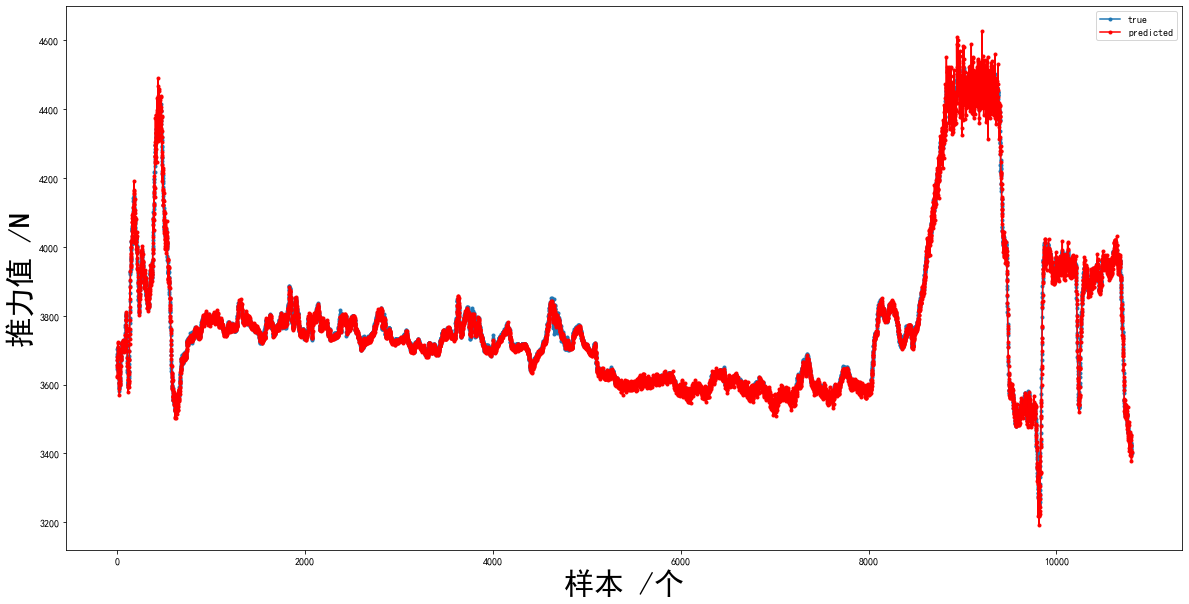

In [29]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();